In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'glove840b300dtxt:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F8327%2F11650%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T142700Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05b502dec8b4fe87dc9bdffdb24f055e202a943518db112e6fefb0f09a00f28d715602416345bfc0d088863b3d1455c411e5c4458ed498351690063dec828e56a6eabee4e22120c3b369b8a535a30c5357a1e2bd308dcfd5ea932517ce79f1faf97389dccf86a660d1ff501a6a615d24909a5307a3c4fb64f85417a5a2fe6a9be98d1095d5cd59320fe111033910559a8906cd8267bd95dbae23a7c7cf2afea80250bc501a771c578e1dd55013b5a330b7dfa44bee527a34e20bcea19d2ce2aadac02b1d187344b60934b8743581c4853f6bcfbd0f8360f0227959443f78b849cc5beb0a1294fd5e90a7abf0a6bc1a301c2f8ac89674e67c37919397e1eaa46c,emotions-dataset-for-nlp:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F605165%2F1085454%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T142700Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D53e2cc883e7f1abdd69f7a0d5b8acbc25ebd7a923e9504e7c55619eb12785bceabefa4fe7a0624378687154b543df64e413dbf18b0e09919810e3b97791d455f4aa2acfd4282517171f83046126443578694481fd60747f53ecfe796d5118e54a8fd8b2073143f56806f6141bf8b16c909cdcca5d7de0d60504c78ee5e4417d6e642045c0bcc6aaeed93f3e9031d243ef596b5f257b756ec6f44d113fbf2cc92dd895b03509712013a2433db45b8c5f90cbd10afddeff9cef1f6de306ced98f8083c9d8a7549ac0bdac028a4dabbeefa5529996936f926129980cff11802838dc4c0d6712b6364d838cc18fbb5db4eea553beb5eb156df0021fd410f58c047f7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2232946675 bytes downloaded
Downloaded and uncompressed: glove840b300dtxt
[==================================================] 738340 bytes downloaded
Downloaded and uncompressed: emotions-dataset-for-nlp
Data source import complete.


In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Reading dataset and separating them as text and label**

In [ ]:
train_df = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt", sep=";", header= None, names=["text", "label"])
test_df = pd.read_csv("../input/emotions-dataset-for-nlp/test.txt", sep=";", header= None, names=["text", "label"])
val_df = pd.read_csv("../input/emotions-dataset-for-nlp/val.txt", sep=";", header= None, names=["text", "label"])

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Checking for null values in data

In [ ]:
train_df.info()
print()
test_df.info()
print()
val_df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



# Distriution of labels in Train and Test data

In [ ]:
train_df["label"].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [ ]:
test_df["label"].value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

# A sample text from the dataset

In [ ]:
sample = train_df["text"][1]
print(sample)

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


# Text Preprocessing
The preprocessing is done in a few steps:
* Lowercaseing the text
* Removing Numbers
* Removing Punctuations
* Removing Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [ ]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)

    return text

In [ ]:
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)

# Raw text vs Preprocessed Text

In [ ]:
train_df.head()

,text,label,clean_text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


# Label Encoding Labels
This means replcing String objects as labels with integer values

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df["encoded_train_label"] = label_encoder.fit_transform(train_df["label"])
val_df["encoded_val_label"] = label_encoder.transform(val_df["label"])
test_df["encoded_test_label"] = label_encoder.transform(test_df["label"])

In [ ]:
train_df[['label', 'encoded_train_label']].drop_duplicates(keep='first')

,label,encoded_train_label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [ ]:
x_train, x_test, y_train, y_test = train_df["clean_text"], val_df["clean_text"], train_df["encoded_train_label"], val_df["encoded_val_label"]

In [ ]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 943.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=383eee4fbb9f5f92b692dadef2d93b2c4a3769d849112d468a719f3a410729c8
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
pip install keras


In [ ]:
import tensorflow as tf
from tf.keras.utils import to_categorical
from keras.utils import to_categorical

In [ ]:
# from keras.utils import np_utils
# from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras import layers
from keras.models import Sequential

EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

# Converting texts to vectors via tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["clean_text"])

vocab_size = len(tokenizer.word_index) + 1

# Calculating maximum length of a vector

In [ ]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 35


# Zero padding every vector so that they are the same size

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

# One Hot Encoding integer labels

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.utils import to_categorical


In [ ]:
dummy_y_test = to_categorical(y_test)
dummy_y_train = to_categorical(y_train)

# Reading GloVe

In [ ]:
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('../input/glove840b300dtxt/glove.840B.300d.txt','r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 2196018it [03:11, 11471.04it/s]


# Defining CNN-BiLSTM model

In [ ]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           4519500   
                                                                 
 dropout (Dropout)           (None, 35, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 33, 32)            28832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 32)            0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 11, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 32)             3104      
                                                        

In [ ]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback])
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/30
125/125 [==============================] - 34s 185ms/step - loss: 1.3881 - accuracy: 0.4522 - val_loss: 0.9008 - val_accuracy: 0.6640
Epoch 2/30
125/125 [==============================] - 21s 171ms/step - loss: 0.7768 - accuracy: 0.7064 - val_loss: 0.4529 - val_accuracy: 0.8465
Epoch 3/30
125/125 [==============================] - 23s 185ms/step - loss: 0.4737 - accuracy: 0.8298 - val_loss: 0.3123 - val_accuracy: 0.8945
Epoch 4/30
125/125 [==============================] - 22s 176ms/step - loss: 0.3465 - accuracy: 0.8781 - val_loss: 0.2398 - val_accuracy: 0.9135
Epoch 5/30
125/125 [==============================] - 23s 180ms/step - loss: 0.2733 - accuracy: 0.9053 - val_loss: 0.2219 - val_accuracy: 0.9215
Epoch 6/30
125/125 [==============================] - 28s 221ms/step - loss: 0.2340 - accuracy: 0.9156 - val_loss: 0.2049 - val_accuracy: 0.9240
Epoch 7/30
125/125 [==============================] - 28s 220ms/step - loss: 0.2008 - accuracy: 0.9305 - val_loss: 0.1993 - val_ac

In [ ]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

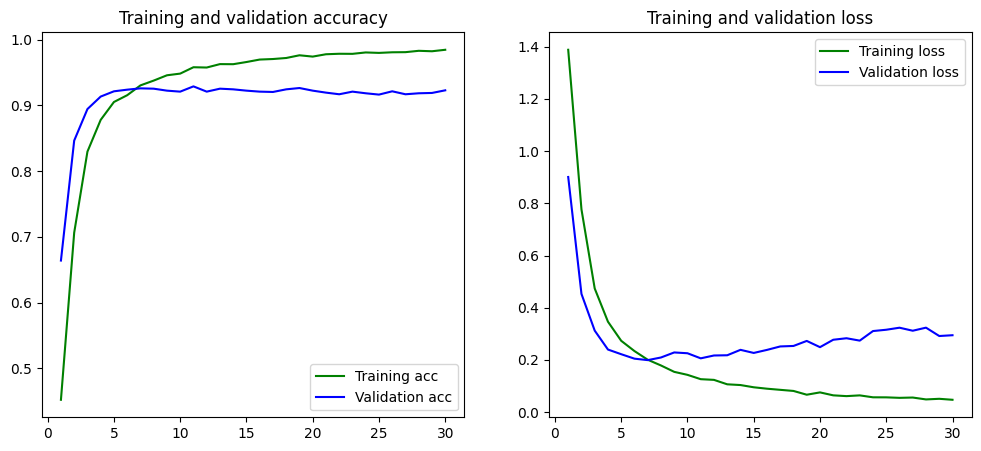

In [ ]:
PlotGraph(history)

In [ ]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.9290000200271606


In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

63/63 [==============================] - 3s 22ms/step


array([4, 4, 4, ..., 2, 2, 1])

# Performance Matrices

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["encoded_test_label"], predict_class)
cm

array([[254,   7,   3,   0,  10,   1],
       [ 12, 196,   0,   0,   9,   7],
       [  0,   5, 642,  42,   2,   4],
       [  2,   0,  19, 137,   1,   0],
       [ 12,   5,   7,   1, 556,   0],
       [  2,  11,   2,   0,   2,  49]])

<Axes: >

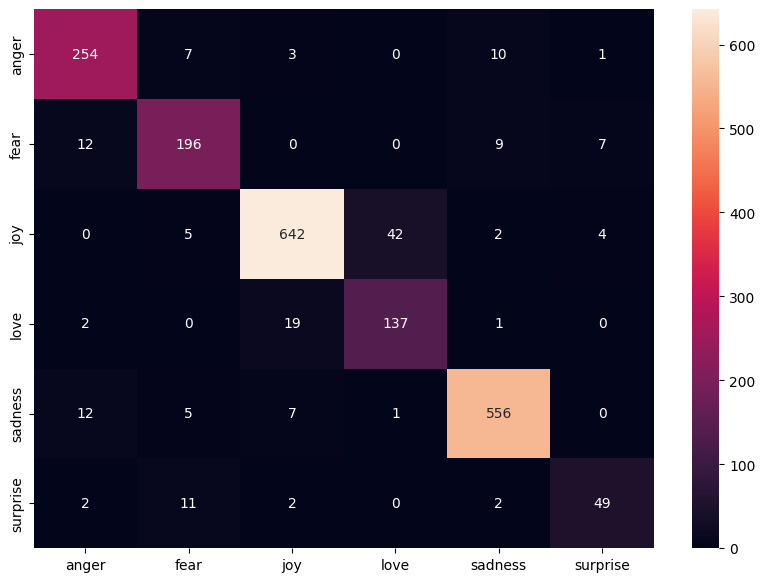

In [ ]:
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df["encoded_test_label"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.90      0.92      0.91       275
        fear       0.88      0.88      0.88       224
         joy       0.95      0.92      0.94       695
        love       0.76      0.86      0.81       159
     sadness       0.96      0.96      0.96       581
    surprise       0.80      0.74      0.77        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000

